In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
#create engine using hawaii.sqlite database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model using automap_base()
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found with .keys()
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
##Use the session to query and display
for row in session.query(Measurement, Measurement.station).limit(5).all():
    print(row)

(<sqlalchemy.ext.automap.measurement object at 0x7fd0ad2bb898>, 'USC00519397')
(<sqlalchemy.ext.automap.measurement object at 0x7fd0ad2bb908>, 'USC00519397')
(<sqlalchemy.ext.automap.measurement object at 0x7fd0ad2bb978>, 'USC00519397')
(<sqlalchemy.ext.automap.measurement object at 0x7fd0ad2bb9e8>, 'USC00519397')
(<sqlalchemy.ext.automap.measurement object at 0x7fd0ad2bba58>, 'USC00519397')


# Exploratory Climate Analysis

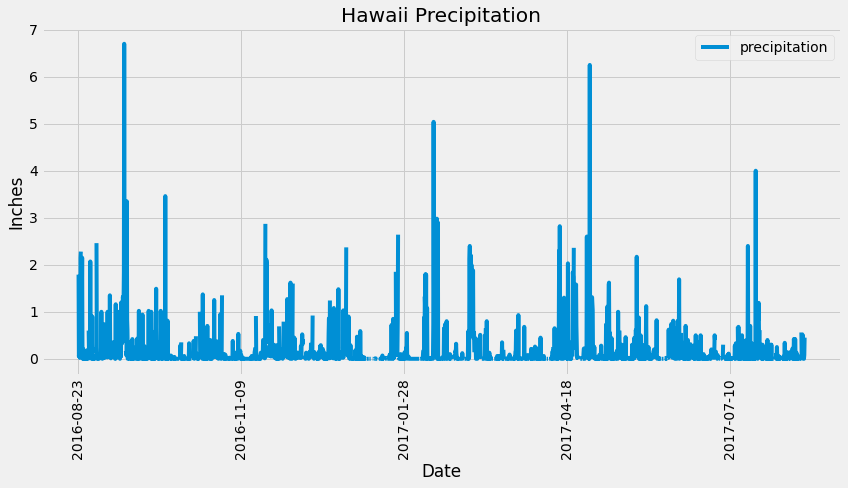

In [32]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
query_date

# Perform a query to retrieve the data and precipitation scores
precip_scores = session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date >= query_date).all()
precip_scores

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precip_df = pd.DataFrame(precip_scores).sort_values(by="date").set_index("date")

precipitation_df = precip_df.rename(columns={"prcp": "precipitation"})

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(rot=90, figsize=(12,7), grid=True)

plt.title("Hawaii Precipitation")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("Images/Precipitation.png")
plt.show()

##example of how to handle plot if using df with additional columns
# x_values = precip_df["date"]
# y_values = precip_df["prcp"]

# precip_df.plot(x_values, y_values)



In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
# summary_stats = precipitation_df.groupby("date").agg({"precipitation" : ["sum", "mean", "median", "var", "std", "sem"]})
# summary_stats

precipitation                                               
                     sum      mean median       var       std       sem
date                                                                   
2016-08-23          2.71  0.451667  0.100  0.499097  0.706468  0.288414
2016-08-24          9.33  1.555000  1.800  0.706510  0.840541  0.343150
2016-08-25          0.54  0.077143  0.080  0.005157  0.071813  0.027143
2016-08-26          0.10  0.016667  0.015  0.000267  0.016330  0.006667
2016-08-27          0.32  0.064000  0.020  0.006680  0.081731  0.036551
...                  ...       ...    ...       ...       ...       ...
2017-08-19          0.09  0.030000  0.000  0.002700  0.051962  0.030000
2017-08-20          0.01  0.005000  0.005  0.000050  0.007071  0.005000
2017-08-21          0.58  0.193333  0.020  0.100933  0.317700  0.183424
2017-08-22          0.50  0.166667  0.000  0.083333  0.288675  0.166667
2017-08-23          0.53  0.132500  0.040  0.046225  0.215000  0.107500

[366 rows x 6 columns]

In [14]:
precip_summary = precipitation_df.describe()
precip_summary

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [43]:
# Design a query to show how many stations are available in this dataset?
count_stations = session.query(Station.name).count()
print(f"There are {count_stations} stations available in this dataset.")

There are 9 stations available in this dataset.


In [49]:
# What are the most active stations? (i.e. what stations have the most rows)?
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                                .group_by(Measurement.station)\
                                .order_by(func.count(Measurement.station).desc())\
                                .all()

# List the stations and the counts in descending order.
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [50]:
#create a Pandas Dataframe to display the stations and counts in descending order
active_stations_df = pd.DataFrame(active_stations, columns=["Station ID", "Observation Counts"])
active_stations_df

,Station ID,Observation Counts
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [51]:
#set variable for the most active station
most_active = session.query(Measurement.station, func.count(Measurement.station))\
                                .group_by(Measurement.station)\
                                .order_by(func.count(Measurement.station).desc())\
                                .first()
most_active

#retrieve station id
most_active_id = most_active[0]
print(f"The most active station is {most_active_id}.")

The most active station is USC00519281.


In [52]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

active_id_temps = session.query(Measurement.station, func.min(Measurement.tobs),
                                func.max(Measurement.tobs), func.avg(Measurement.tobs))\
                                .group_by(Measurement.station)\
                                .filter(Measurement.station == most_active_id)

active_id_temps

#display in a Pandas Dataframe
active_id_temps_df = pd.DataFrame(active_id_temps, columns=["Station ID", "min temp", "max temp", "avg temp"])
active_id_temps_df

,Station ID,min temp,max temp,avg temp
0,USC00519281,54.0,85.0,71.663781


In [53]:
# Choose the station with the highest number of temperature observations.
most_temps = session.query(Measurement.station, func.count(Measurement.tobs))\
                                .group_by(Measurement.station)\
                                .order_by(func.count(Measurement.tobs).desc())\
                                .first()
most_temps

most_temps_id = most_temps[0]
print(f"The station with the highest number of temperature observations is {most_temps_id}.")

The station with the highest number of temperature observations is USC00519281.


In [54]:
# Query the last 12 months of temperature observation data for this station
# plot the results as a histogram
temp_data = session.query(Measurement.date, Measurement.tobs).\
                    filter(Measurement.date >= query_date).\
                    filter(Measurement.station == most_temps_id).all()
temp_data

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
temp_df = pd.DataFrame(temp_data).sort_values(by="date").set_index("date")

temp_df = temp_df.rename(columns={"tobs": "temperatures"})
temp_df

,temperatures
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


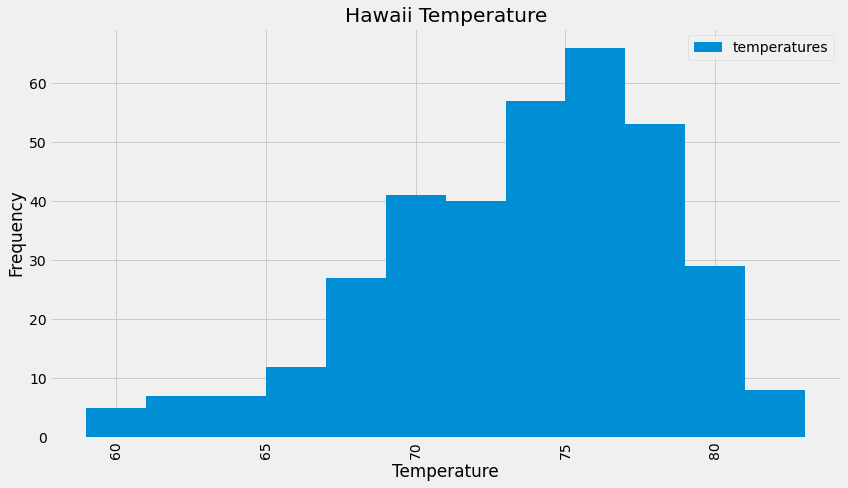

In [55]:
# Use Pandas Plotting with Matplotlib to plot the data
temp_df.plot(kind="hist", rot=90, figsize=(12,7), grid=True, bins=12)

plt.title("Hawaii Temperature")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("Images/Temperature.png")
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
